In [12]:
import pyCloudy as pc
import pyneb
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import re
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) #TJ change directory to include the entire ASTRO5160 directory
from Py_files.Basic_analysis import *

def parse_emission_lines(model_name, target_string, wl_range):
    """
    Parse a file and extract emission line data matching the pattern:
    [Capital letter][optional lowercase letter] space integer (e.g., H  1 or He 2)
    followed by wavelength, flux values, etc.
    
    Args:
        model_name: type = str - model_name used to find the output file you want to parse
        target_string: type = str - species you want expected fluxes for. "H  1" for example, note the two spaces between H and 1.
        wl_range: type = list - [shortest wavelength, longest wavelength] representing the range we are interested in (in meters)
    Returns:
        list: List of lists, each containing [species, wavelength, flux1, flux2, ...]
    """
    filename = f'{model_name}.out'
    results = []
    iteration_pattern = re.compile(r'Iteration\s+(\d+)\s+of\s+(\d+)')
    final_iteration = False

    with open(filename, 'r') as file:
        line_type = None

        for i, line in enumerate(file):
            if not final_iteration:
                iteration_match = iteration_pattern.search(line)
                if iteration_match:
                    n, m = iteration_match.groups()
                    if n == m:
                        final_iteration = True
                continue  # Skip processing until we find the iteration line
            # Find all matches of the pattern in the current line
            if 'Intrinsic line intensities' in line:
                line_type = 'intrinsic'
            if 'Emergent line intensities' in line:
                line_type = 'emergent'
            if target_string in line:
                start = line.index(target_string)
                remaining = line[start + len(target_string):].strip()
                parts = remaining.split()
    
                if len(parts) >= 2:
                    species = target_string.replace(" ", "")  # → "H1"
                    wavelength = parts[0]
                    flux = parts[1]
                    flux_norm = parts[2]
                    if ((type(try_float(flux_norm)) == float) & (type(try_float(flux)) == float) & (type(try_float(wavelength[:-1])) == float)):
                        results.append([species, wavelength, flux, flux_norm, i, line_type])
    wavelengths = []
    relative_fluxes = []
    fluxes = []
    types = []
    line_index = []
    for row in results:
        wavelength_str = row[1]
        if 'm' in wavelength_str:  # Convert meters to Angstroms
            wavelength = float(wavelength_str.replace('m', '')) * 1e-6
        elif 'A' in wavelength_str:  # Already in Angstroms
            wavelength = float(wavelength_str.replace('A', '')) * 1e-10
        else:  # Assume Angstroms if no unit
            wavelength = float(wavelength_str)
        if ((wavelength > wl_range[0]) & (wavelength < wl_range[1])):
                
            # Extract relative flux (4th column)
            relative_flux = float(row[3])
            
            wavelengths.append(wavelength)
            relative_fluxes.append(relative_flux)
            fluxes.append(float(row[2]))
            types.append(row[-1])
            line_index.append(row[-2])
    return {
        'wavelength': np.array(wavelengths),
        'relative_flux': np.array(relative_fluxes),
        'flux': np.array(fluxes),
        'type': np.array(types),
        'line_index': line_index
        }    


def print_output_file(model_name):
    '''Simply print the output file with the specified model name, returns nothing, used just to view output file.'''
    with open(f'{model_name}.out', 'r') as f:
        print(f.read())
    return None


def write_CLOUDY_input_file(model_name):
    """
    Write the CLOUDY input file. Be sure to double check the parameters because this function does not accept any arguments for parameters
    
    Args:
        model_name: type = str - string that will be the input and output filename
                        check function script to view what parameters are being assumed.
    Returns:
        input_file : type = str - string to the input file, can then be used in "os.system(f'{cloudy_path} -r {input_file}')"
    """
    
    input_file = f"{model_name}.in"
    
    with open(input_file, 'w') as f:
        f.write(f'title {model_name}\n')
        f.write(f'Ionization parameter -2\n')
        f.write(f'table SED "fsps_young.ascii"\n')
        f.write(f'hden 3\n')
        f.write(f'cmb\n')
        f.write('iterate to convergence\n') 
        f.write(f'stop temperature 100 K\n')  # Stop condition
        f.write(f'stop neutral column density 10\n')
        f.write('set temperature floor 2.73\n')
        f.write('set nchrg 2\n')
        f.write('normalize to "H  1" 18751.0 angstroms\n')  # Normalization to paschen alpha
        f.write('no level 2 lines\n') # Case B only
        f.write('abundances ism\n')
        f.write('grains ISM abundance scaling 1.5\n')
        f.write('COSMIC RAYS BACKGROUND\n')
        f.write(f'save lines sum, array {model_name} "H  1" no extinction\n')
        f.write('save grains extinction "extinction.dat"\n')
        #f.write('print line intrinsic\n')
        #f.write('print line vacuum\n')
    return input_file.split('.i')[0]

def run_CLOUDY(model_name):
    """
    Runs the CLOUDY model using the input file with the name model_name
    
    Args:
        model_name: type = str - string that will be the input and output filename
                        check write_CLOUDY_input_file() function script to view what parameters are being assumed.
    Returns:
        h1_array: type = structured array - columns for 'wavelength' and 'relative_flux'
    """
    
    cloudy_path = "/d/ret1/Taylor/CLOUDY/c23.01/source/cloudy.exe"
    
    cloudy_input_file = write_CLOUDY_input_file(model_name)
    print(f'Running CLOUDY model using input file : {cloudy_input_file}.in')
    os.system(f'{cloudy_path} -r {cloudy_input_file}')
    h1_array = parse_emission_lines(model_name, "H  1", [0.96e-6, 28.095e-6])
    return h1_array

In [13]:
model_name = 'young_test3'
data2 = run_CLOUDY(model_name)
print_output_file(model_name)


Running CLOUDY model using input file : young_test3.in
                                                          Cloudy 23.01
                                                         www.nublado.org

                                                  PRNG seed: 0x6b749a2411e4820c

                       **************************************23Jul25**************************************
                       *                                                                                 *
                       * title young test3                                                               *
                       * Ionization parameter -2                                                         *
                       * table SED "fsps_young.ascii"                                                    *
                       * hden 3                                                                          *
                       * cmb                                                 

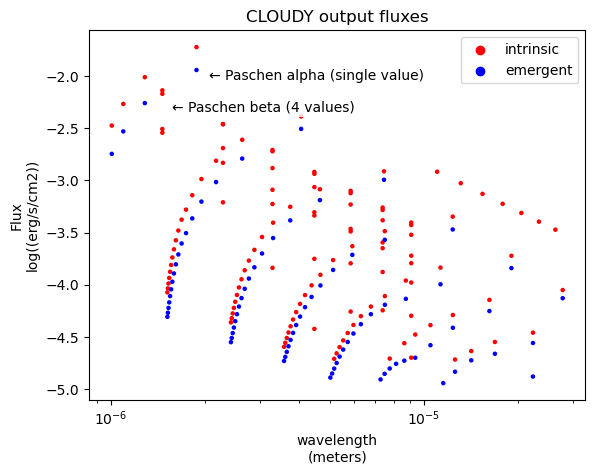

In [11]:
colors = np.array(['red' if x == 'intrinsic' else 'blue' for x in data2['type']])
plt.scatter(data2['wavelength'], data2['flux'], s = 5, color = colors)
plt.scatter([], [], color = 'red', label = 'intrinsic')
plt.scatter([], [], color = 'blue', label = 'emergent')
ymin, ymax = plt.ylim()
alpha_y_pos = ymax * 0.9
# Add NIRCam label to the left
plt.text(1e-5, -2, "← Paschen alpha (single value)", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

beta_y_pos = ymax * 0.45

# Add NIRCam label to the left
plt.text(6e-6, -2.3, "← Paschen beta (4 values)", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

plt.title('CLOUDY output fluxes')
plt.ylabel('Flux\nlog((erg/s/cm2))')
plt.xlabel('wavelength\n(meters)')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()


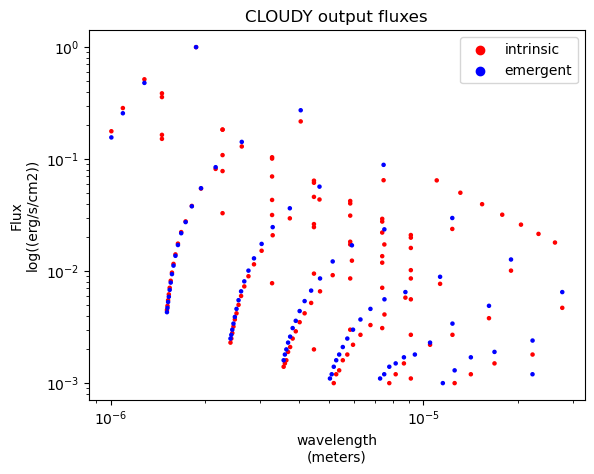

In [89]:
colors = np.array(['red' if x == 'intrinsic' else 'blue' for x in data['type']])
plt.scatter(data['wavelength'], data['relative_flux'], s = 5, color = colors)
plt.scatter([], [], color = 'red', label = 'intrinsic')
plt.scatter([], [], color = 'blue', label = 'emergent')
ymin, ymax = plt.ylim()
alpha_y_pos = ymax * 0.9
# Add NIRCam label to the left
'''plt.text(1e-5, -2, "← Paschen alpha (single value)", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

beta_y_pos = ymax * 0.45

# Add NIRCam label to the left
plt.text(6e-6, -2.3, "← Paschen beta (4 values)", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)
'''
plt.title('CLOUDY output fluxes')
plt.ylabel('Flux\nlog((erg/s/cm2))')
plt.xlabel('wavelength\n(meters)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [66]:
sort_indices = np.argsort(data['wavelength'])

# Create new sorted dictionary
sorted_result = {
    'wavelength': data['wavelength'][sort_indices],
    'relative_flux': data['relative_flux'][sort_indices]
}
sorted_result


{'wavelength': array([1.00494e-06, 1.00494e-06, 1.09381e-06, 1.09381e-06, 1.28181e-06,
        1.28181e-06, 1.45842e-06, 1.45842e-06, 1.45842e-06, 1.45842e-06,
        1.51332e-06, 1.51332e-06, 1.51919e-06, 1.51919e-06, 1.52605e-06,
        1.52605e-06, 1.53418e-06, 1.53418e-06, 1.54389e-06, 1.54389e-06,
        1.55565e-06, 1.55565e-06, 1.57007e-06, 1.57007e-06, 1.58805e-06,
        1.58805e-06, 1.61093e-06, 1.61093e-06, 1.64072e-06, 1.64072e-06,
        1.68065e-06, 1.68065e-06, 1.73621e-06, 1.73621e-06, 1.81741e-06,
        1.81741e-06, 1.87510e-06, 1.87510e-06, 1.94456e-06, 1.94456e-06,
        2.16553e-06, 2.16553e-06, 2.27878e-06, 2.27878e-06, 2.27878e-06,
        2.27878e-06, 2.27878e-06, 2.41573e-06, 2.41573e-06, 2.43070e-06,
        2.43070e-06, 2.44833e-06, 2.44833e-06, 2.46931e-06, 2.46931e-06,
        2.49458e-06, 2.49458e-06, 2.52540e-06, 2.52540e-06, 2.56363e-06,
        2.56363e-06, 2.61194e-06, 2.61194e-06, 2.62515e-06, 2.62515e-06,
        2.67440e-06, 2.67440e-06, 2.7